### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *
from pprint import pprint
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import levene

%matplotlib inline

#### Importing Dataset

In [2]:
ls

'2019 County Health Rankings Data - v2.xls'*   marc_index.ipynb
 analytic_data2019.csv*                        __pycache__/
 clean.csv                                     README.md
 external_modules/                             shuyu_index.ipynb
 functions.py


### If the cleaning process has already been done jump to import the cleaned csv later in the file

In [3]:
xls = pd.ExcelFile('2019 County Health Rankings Data - v2.xls')
df = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [4]:
df.head()

,FIPS,State,County,Life Expectancy,95% CI - Low,95% CI - High,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,...,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.16,95% CI - High.16,% Female,# Rural,% Rural
0,1001,Alabama,Autauga,76.330589,75.554117,77.107061,74.600628,NaN,76.337219,815.0,...,2.857452,41336,74.473912,430,0.828548,0.422472,1.234624,51.342246,22921.0,42.002162
1,1003,Alabama,Baldwin,78.599498,78.208357,78.990639,75.628919,98.039893,78.537003,2827.0,...,4.550200,176582,83.047388,872,0.454512,0.282144,0.626880,51.452772,77060.0,42.279099
2,1005,Alabama,Barbour,75.779457,74.639355,76.919559,74.240228,NaN,77.568384,451.0,...,4.206569,11613,45.955679,297,1.199273,0.580536,1.818011,47.229917,18613.0,67.789635
3,1007,Alabama,Bibb,73.928271,72.624611,75.231931,72.294686,NaN,74.109510,445.0,...,2.638080,16842,74.298571,84,0.394348,0.000000,0.933361,46.453150,15663.0,68.352607
4,1009,Alabama,Blount,74.597767,73.810999,75.384535,NaN,78.577094,74.098247,1050.0,...,9.565097,50439,86.944306,1013,1.870004,1.364180,2.375829,50.688639,51562.0,89.951502


In [5]:
df.select_dtypes(include=['object'])[:2]

,State,County,Other PCP Ratio
0,Alabama,Autauga,3265:1
1,Alabama,Baldwin,1916:1


### Exploratory Data Analysis

#### Renaming columns

In [6]:
columns_name = df.columns
new_column_names = []
for column_name in columns_name:
    new_column_names.append(column_name.replace(" ", "_"))
pprint(new_column_names[:5])
df.columns = new_column_names

['FIPS', 'State', 'County', 'Life_Expectancy', '95%_CI_-_Low']


#### Renaming counties

In [7]:
county_names = df["County"]
new_county_names = []
for county_name in county_names:
    new_county_names.append(county_name.replace(" ", "_"))
df["County"] = new_county_names

#### Dropping ethnicies columns and columns with a lot of missing values

In [8]:
to_drop = ["Other_PCP_Ratio", "FIPS", "Segregation_index", "Segregation_Index" , "%_Free_or_Reduced_Lunch", "#_HIV_Cases", "HIV_Prevalence_Rate"]
#Data is missing for HIV only in South Dakota, replace it by country weighted average later or look at this column in depth
containing = ["CI_-_Low", "CI_-_High", "#_","White", "Hispanic", "Black", "Asian" ,"Alaskan", "Indian", "Hawaiian", "African"]
for column in df.columns:
    if (column in to_drop) or any(word in column for word in containing):
        df = df.drop([column], axis=1)

In [9]:
df.columns

Index(['State', 'County', 'Life_Expectancy', 'Age-Adjusted_Mortality',
       'Child_Mortality_Rate', 'Infant_Mortality_Rate',
       '%_Frequent_Physical_Distress', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured', '%_Uninsured.1',
       'Other_PCP_Rate', '%_Disconnected_Youth', 'Household_Income',
       'Homicide_Rate', 'Firearm_Fatalities_Rate', '%_Homeowners',
       '%_Severe_Housing_Cost_Burden', 'Population', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Female', '%_Rural'],
      dtype='object')

In [11]:
ren_col = {"Household_Income": "Household_Median_Income",
           "%_Uninsured": "%_Uninsured_adults",
           "%_Uninsured.1" : "%_Uninsured_children",
           "%_Limited_Access": "%_Limited_Access_Healthy_Food"}

In [12]:
df.rename(columns=ren_col, inplace=True)

#### Delete rows missing Life Expectancy

In [13]:
df = df.dropna(subset=["Life_Expectancy"])

### Fill counties missing values using states weighted averages

In [14]:
df.head(2)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099


#### Calculate the weighted averages for each columns in each states

In [15]:
states = list(df.State.unique())
columns = [x for x in list(df.columns) if x not in ["State", "County"]]

In [16]:
state_wv = {}
for state in states:
    df_state = df.loc[df["State"] == state]
    for column in columns:
        values = df_state.dropna(subset=[column])[column]
        population_value = df_state.dropna(subset=[column])["Population"].astype(np.float64)
        population = np.sum(df_state.dropna(subset=[column])["Population"])
        if population != 0:
            wv = (values * population_value).sum() / population
            if not state_wv.get(state):
                state_wv[state] = {}
            state_wv[state][column] = float(wv)
        else:
            print(f"No data for {column} in {state}")

#### Fill each missing values by states weighted averages

In [17]:
df_filled = df.copy()
for index in df.index:
    for column in df.columns:
        if column not in ["State","County"]:
            if np.isnan(df[column][index]):
                df_filled[column][index] = state_wv[df["State"][index]][column]

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
df_filled.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


#### Saving cleaned DataFrame to csv file

In [19]:
df_filled.to_csv(r"/home/locsta/Documents/FlatIron/County-Health-Analysis/clean.csv", index=False)

### Importing Cleaned CSV

In [2]:
df = pd.read_csv("clean.csv")
df.head(3)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635


#### Plot variables distribution

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


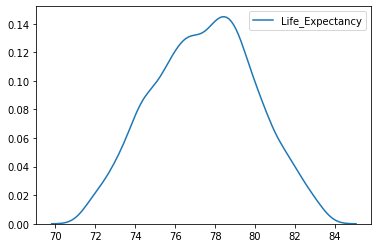

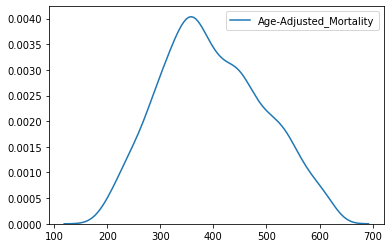

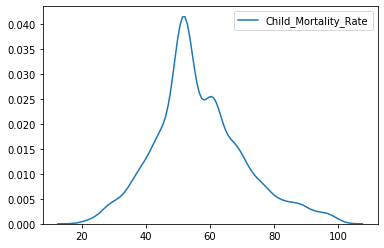

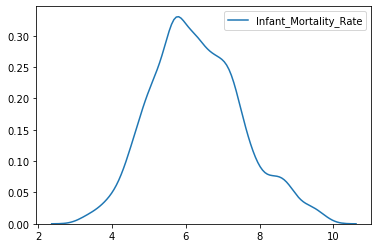

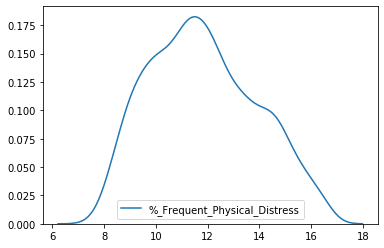

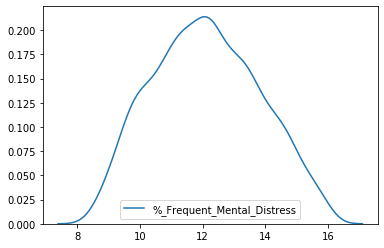

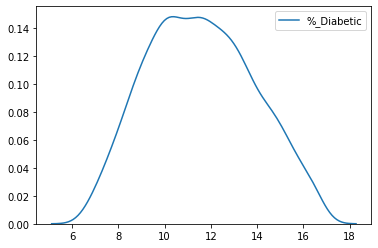

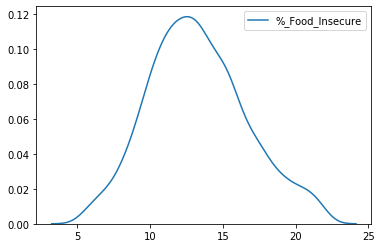

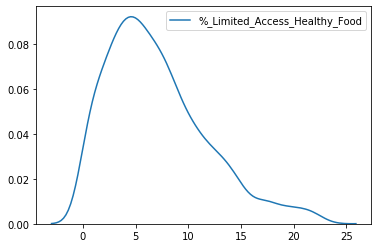

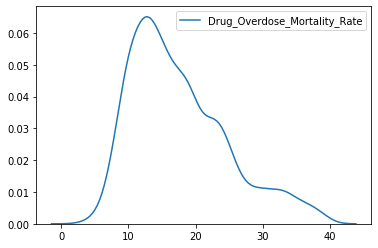

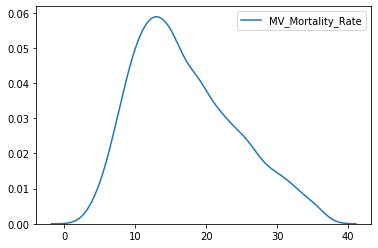

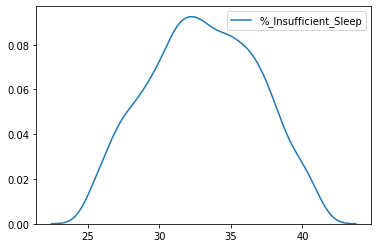

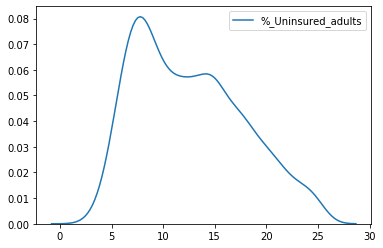

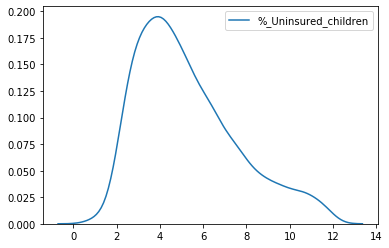

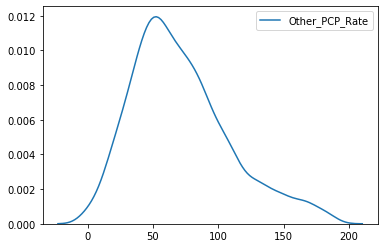

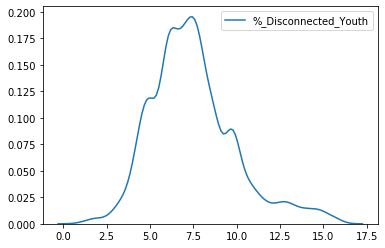

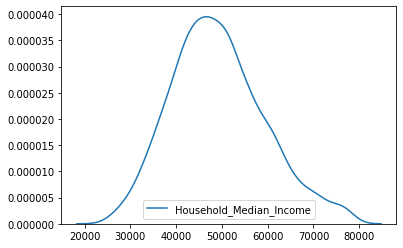

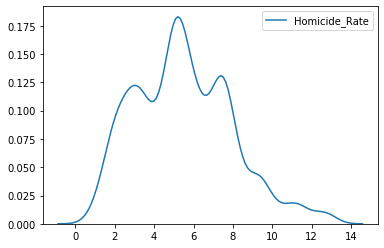

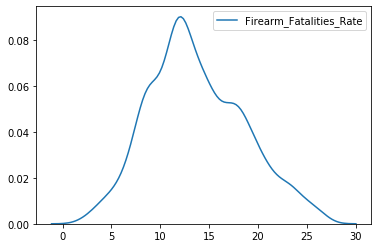

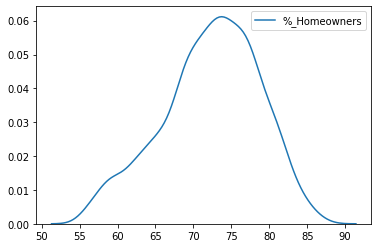

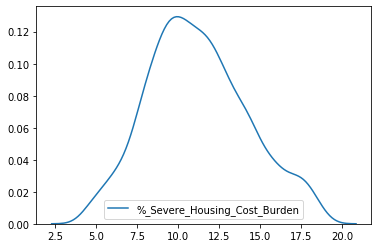

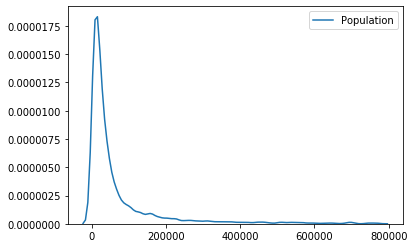

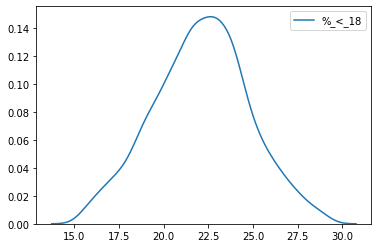

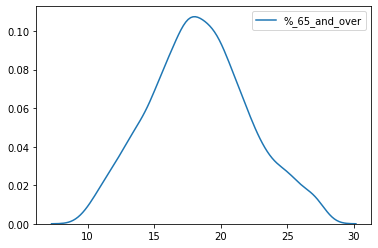

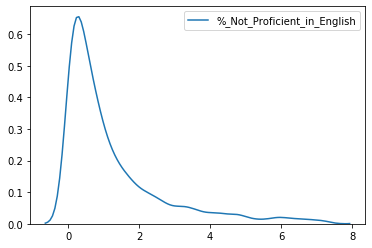

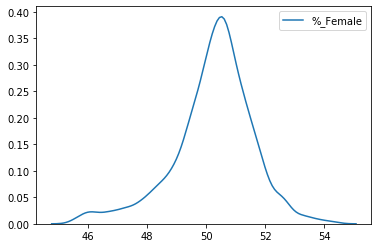

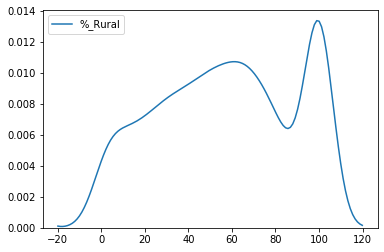

In [3]:
for i, column in enumerate(df.drop(["State", "County"], axis=1).columns):
    plt.figure(i)
    min_x = (df[column].mean()-(2*df[column].std()))
    max_x = (df[column].mean()+(2*df[column].std()))
    sns.kdeplot(df[column], clip=(min_x, max_x))

#### Transform numerical columns using log

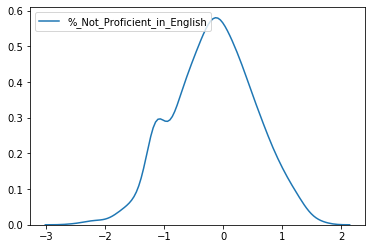

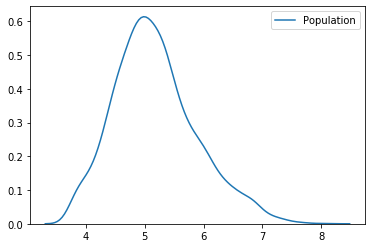

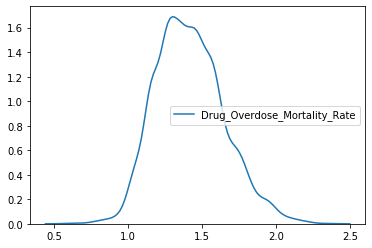

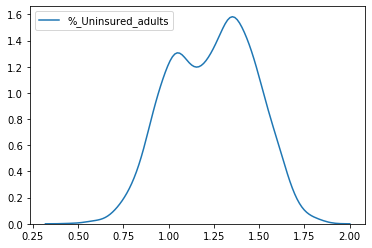

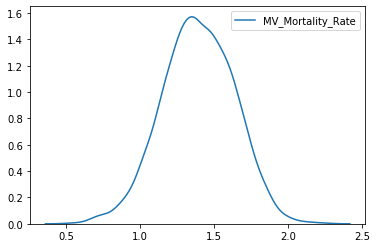

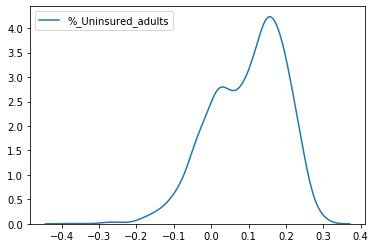

In [4]:
to_log = ["%_Not_Proficient_in_English", "Population" ,"Drug_Overdose_Mortality_Rate", "%_Uninsured_adults","MV_Mortality_Rate", "%_Uninsured_adults"]
# to_categories = ["Other_PCP_Rate","Population", "%_Rural"] #Maybe!
# ["%_Limited_Access_Healthy_Food"]   <= to many std away from mean at the lower end of the tail
for i, column in enumerate(to_log):
    df[column]=df[column].replace(0,0.1)
    df[column] = df[column].map(lambda x: np.log(np.sqrt(x)))
    plt.figure(i)
    sns.kdeplot(df[column])

#### Turn State column into category and drop County

In [5]:
df["State"] = df["State"].astype('category')
df = df.drop(["County"], axis=1)

#### Creating dummy variables

In [6]:
df["State"] = df["State"].cat.codes

#### Verify non multicollinearity over 75%

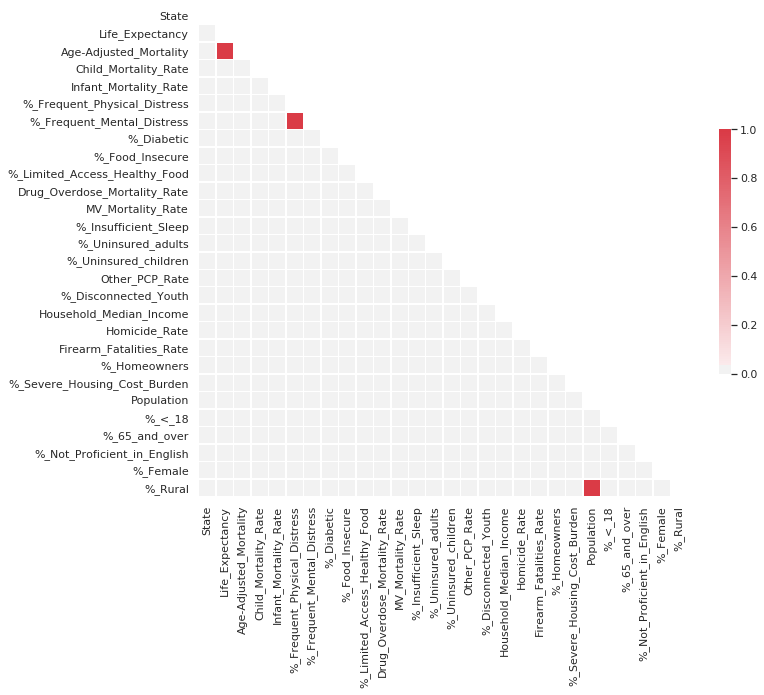

In [7]:
print_corr(df, 0.75)

#### Dropping highly correlated features

In [8]:
to_drop = ["Age-Adjusted_Mortality", "%_Frequent_Physical_Distress", "Population"]
for col in to_drop:
    df = df.drop([col], axis=1)

#### Checking p-values

In [9]:
results, columns_to_drop = p_dropping(df, target="Life_Expectancy", p_value=0.05)

/home/locsta/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [10]:
columns_to_drop

['Life_Expectancy',
 '%_Female',
 '%_Uninsured_adults',
 '%_Disconnected_Youth',
 'Infant_Mortality_Rate',
 '%_Homeowners']

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_Expectancy   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     370.1
Date:                Tue, 14 Jan 2020   Prob (F-statistic):               0.00
Time:                        14:36:43   Log-Likelihood:                -5901.0
No. Observations:                3073   AIC:                         1.184e+04
Df Residuals:                    3053   BIC:                         1.196e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            90.8625      0.775    117.192      0.000      89.342      92.383
State                            -0.0086      0.002     -3.890      0.000      -0.013      -0.004
Child_Mortality_Rate             -0.0163      0.002     -8.525      0.000      -0.020      -0.013
%_Frequent_Mental_Distress       -0.1128      0.034     -3.294      0.001      -0.180      -0.046
%_Diabetic                       -0.2046      0.022     -9.431      0.000      -0.247      -0.162
%_Food_Insecure                  -0.0830      0.013     -6.147      0.000      -0.109      -0.057
%_Limited_Access_Healthy_Food     0.0130      0.004      2.933      0.003       0.004       0.022
Drug_Overdose_Mortality_Rate     -1.6108      0.166     -9.733      0.000      -1.935      -1.286
MV_Mortality_Rate                -2.4838      0.186    -13.333      0.000      -2.849      -2.119
%_Insufficient_Sleep             -0.0677      0.013     -5.099      0.000      -0.094      -0.042
%_Uninsured_children              0.0471      0.013      3.669      0.000       0.022       0.072
Other_PCP_Rate                   -0.0029      0.001     -5.142      0.000      -0.004      -0.002
Household_Median_Income        5.307e-05   3.86e-06     13.737      0.000    4.55e-05    6.06e-05
Homicide_Rate                     0.0333      0.012      2.809      0.005       0.010       0.057
Firearm_Fatalities_Rate          -0.0374      0.006     -5.769      0.000      -0.050      -0.025
%_Severe_Housing_Cost_Burden      0.0291      0.011      2.536      0.011       0.007       0.052
%_<_18                           -0.1539      0.013    -11.709      0.000      -0.180      -0.128
%_65_and_over                     0.0427      0.011      3.721      0.000       0.020       0.065
%_Not_Proficient_in_English       0.4839      0.058      8.282      0.000       0.369       0.599
%_Rural                           0.0089      0.001      6.127      0.000       0.006       0.012
==============================================================================
Omnibus:                      696.054   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9083.580
Skew:                           0.699   Prob(JB):                         0.00
Kurtosis:                      11.306   Cond. No.                     1.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Dropping columns with high p-values

In [12]:
for col in columns_to_drop:
    if col == "Life_Expectancy":
        continue
    df = df.drop([col], axis=1)

### Checking normality assumption

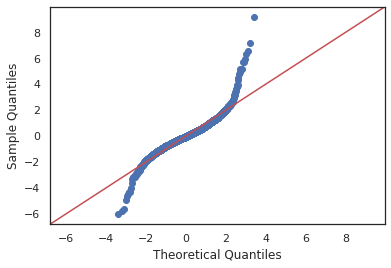

In [13]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)

In [14]:
rows_b = len(df)
df = df[df["Life_Expectancy"] < np.percentile(df["Life_Expectancy"],95)]
rows_a = len(df)
r_dropped = rows_b - rows_a

Removing the top 5% values for Life Expectancy removed 154 rows (0.05%)


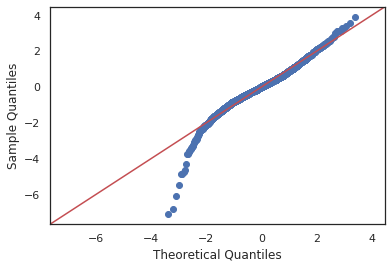

In [15]:
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
print(f"Removing the top 5% values for Life Expectancy removed {r_dropped} rows ({round(r_dropped/rows_b, 2)}%)")

In [16]:
rows_b = len(df)
df = df[df["Life_Expectancy"] > np.percentile(df["Life_Expectancy"],5)]
rows_a = len(df)
r_dropped = rows_b - rows_a

Removing the bottom 5% values for Life Expectancy removed 146 rows (0.05%)


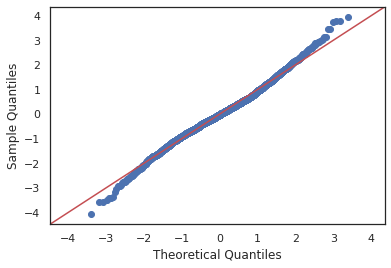

In [17]:
y = df["Life_Expectancy"].astype('float')
X = sm.add_constant(df.drop(["Life_Expectancy"], axis=1).astype('float'))
model = sm.OLS(y, X)
results = model.fit()
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
print(f"Removing the bottom 5% values for Life Expectancy removed {r_dropped} rows ({round(r_dropped/rows_b, 2)}%)")

### Check Homoscedasticity Assumption

In [18]:
t, p = levene(results.predict(X), df["Life_Expectancy"])
print(f"t-stat: {t}, p-value: {p}")
print("The predictions and real values DON'T have the same variance") if p > 0.05 else print("The predictions and real values have the same variance")

t-stat: 144.7413885377846, p-value: 6.271332902283854e-33
The predictions and real values have the same variance


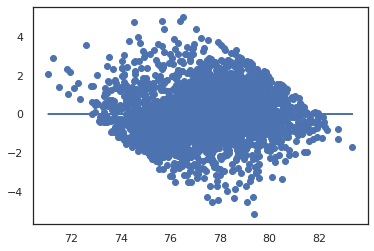

In [19]:
plt.scatter(results.predict(X), results.resid)
plt.plot(results.predict(X), [0 for i in range(len(df))])

### Split the data into train and test

In [20]:
#Use Life_Expectancy as Target and the other columns has parameters
X_train, X_test, y_train, y_test = train_test_split(df.drop(["Life_Expectancy"], axis=1).astype('float'), df["Life_Expectancy"].astype('float'), test_size=0.25, random_state=42)

In [21]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Cross-validation

In [22]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=10)
baseline = np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation))
print(f"The baseline R-Squared is {baseline}")

The baseline R-Squared is 0.6726282138560578


### Feature Engineering

#### Interactions

In [23]:
from itertools import combinations
combinations = list(combinations(X_train.columns, 2))

In [24]:
interactions = []
data = X_train.copy()
for comb in combinations:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y_train, scoring='r2', cv=crossvalidation))
    if score > baseline: interactions.append((comb[0], comb[1], round(score, 3)))
            
print('Top 7 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:7])
data = data.drop(["interaction"], axis=1)

Top 7 interactions: [('%_Diabetic', '%_Insufficient_Sleep', 0.681), ('State', '%_Uninsured_children', 0.677), ('%_Diabetic', 'Homicide_Rate', 0.677), ('%_Diabetic', '%_<_18', 0.677), ('%_Food_Insecure', '%_Insufficient_Sleep', 0.677), ('%_Food_Insecure', '%_Severe_Housing_Cost_Burden', 0.677), ('%_Food_Insecure', '%_<_18', 0.677)]


#### Adding top 3 interactions to train and test datasets

In [25]:
X_train["Diabetic*Insufficient_Sleep"] = X_train["%_Diabetic"] * X_train["%_Insufficient_Sleep"]
X_train["Food_Insecure*%_Severe_Housing_Cost_Burden"] = X_train["%_Food_Insecure"] * X_train["%_Severe_Housing_Cost_Burden"]
X_train["%_Food_Insecure*%_Insufficient_Sleep"] = X_train["%_Food_Insecure"] * X_train["%_Insufficient_Sleep"]
X_test["Diabetic*Insufficient_Sleep"] = X_test["%_Diabetic"] * X_test["%_Insufficient_Sleep"]
X_test["Food_Insecure*%_Severe_Housing_Cost_Burden"] = X_test["%_Food_Insecure"] * X_test["%_Severe_Housing_Cost_Burden"]
X_test["%_Food_Insecure*%_Insufficient_Sleep"] = X_test["%_Food_Insecure"] * X_test["%_Insufficient_Sleep"]

In [26]:
print(len(X_train),len(y_train), len(X_test), len(y_test), len(X_train.columns), len(X_test.columns))

2079 2079 694 694 22 22


In [27]:
X_train.columns

Index(['State', 'Child_Mortality_Rate', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access_Healthy_Food',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured_children', 'Other_PCP_Rate',
       'Household_Median_Income', 'Homicide_Rate', 'Firearm_Fatalities_Rate',
       '%_Severe_Housing_Cost_Burden', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Rural', 'Diabetic*Insufficient_Sleep',
       'Food_Insecure*%_Severe_Housing_Cost_Burden',
       '%_Food_Insecure*%_Insufficient_Sleep'],
      dtype='object')

#### Polynomials

In [28]:
polynomials = []
columns = list(X_train.drop(["State"], axis=1).columns)
for col in columns:
    for degree in [2, 3, 4]:
        #Copy the X_train set
        X_ = X_train.drop(["State"], axis=1).copy()
        
        #Instantiate PolynomialFeatures
        poly = PolynomialFeatures(degree, include_bias=False)

        #Fit and transform X_train
        X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
        X_ = pd.concat([X_.drop(col, axis=1),pd.DataFrame(X_poly_train)], axis=1)

        #Instantiate and fit a linear regression model to the polynomial transformed train features
        lm = LinearRegression()
        reg_poly = lm.fit(X_, y_train)

        #Get predicted values for transformed polynomial train data  
        y_pred = reg_poly.predict(X_)

        #Calculate Score
        score = r2_score(y_train, y_pred)
        
        polynomials.append((col, degree, round(score, 3)))
print('Top 10 polynomials: %s' %sorted(polynomials, key=lambda poly: poly[2], reverse=True)[:10])

Top 10 polynomials: [('%_Uninsured_children', 4, 0.703), ('%_Uninsured_children', 3, 0.702), ('Household_Median_Income', 3, 0.701), ('%_Diabetic', 4, 0.7), ('%_Not_Proficient_in_English', 3, 0.7), ('%_Not_Proficient_in_English', 4, 0.7), ('%_Diabetic', 2, 0.699), ('%_Diabetic', 3, 0.699), ('Drug_Overdose_Mortality_Rate', 2, 0.699), ('Drug_Overdose_Mortality_Rate', 3, 0.699)]


#### Adding Polymial features to X

In [29]:
X_ = X_train.drop(["State"], axis=1).copy()
X_t = X_test.drop(["State"], axis=1).copy()
for col in ["%_Uninsured_children", "Household_Median_Income", "%_Diabetic", "%_Not_Proficient_in_English", "Drug_Overdose_Mortality_Rate"]:
    #Instantiate PolynomialFeatures
    poly = PolynomialFeatures(3, include_bias=False)

    #Fit and transform X_train
    X_poly_train = poly.fit_transform(np.array(X_[col]).reshape(-1, 1))
    X_poly_test = poly.transform(np.array(X_t[col]).reshape(-1, 1))
    
    #Add polynomial columns to train and test data sets
    colnames= [col, col + '_^' + '2',  col + '_^' + '3']
    X_train = pd.concat([X_train.drop(col, axis=1),pd.DataFrame(X_poly_train, columns=colnames)], axis=1)
    X_test = pd.concat([X_test.drop(col, axis=1),pd.DataFrame(X_poly_test, columns=colnames)], axis=1)

## Model

#### Check our X_train and X_test data

In [30]:
print(len(X_train),len(y_train), len(X_test), len(y_test), len(X_train.columns), len(X_test.columns))

2079 2079 694 694 32 32


In [31]:
X_train[:3]

,State,Child_Mortality_Rate,%_Frequent_Mental_Distress,%_Food_Insecure,%_Limited_Access_Healthy_Food,MV_Mortality_Rate,%_Insufficient_Sleep,Other_PCP_Rate,Homicide_Rate,Firearm_Fatalities_Rate,...,Household_Median_Income_^3,%_Diabetic,%_Diabetic_^2,%_Diabetic_^3,%_Not_Proficient_in_English,%_Not_Proficient_in_English_^2,%_Not_Proficient_in_English_^3,Drug_Overdose_Mortality_Rate,Drug_Overdose_Mortality_Rate_^2,Drug_Overdose_Mortality_Rate_^3
0,43.0,51.424971,12.193061,8.4,4.064657,1.285861,32.804112,38.25067,5.418223,11.492200,...,7.275194e+13,10.5,110.25,1157.625,1.275730,1.627487,2.076234,1.166404,1.360498,1.586890
1,25.0,61.402048,12.584981,12.4,3.906027,1.504221,31.342165,47.42088,4.100000,14.800000,...,1.750240e+14,13.3,176.89,2352.637,-0.810751,0.657317,-0.532920,1.718746,2.954088,5.077326
2,26.0,56.223458,12.196457,14.0,21.595547,1.465130,28.100493,151.00671,3.413204,19.536086,...,7.501796e+13,9.8,96.04,941.192,-0.093372,0.008718,-0.000814,1.273587,1.622024,2.065788


In [32]:
X_test[:3]

,State,Child_Mortality_Rate,%_Frequent_Mental_Distress,%_Food_Insecure,%_Limited_Access_Healthy_Food,MV_Mortality_Rate,%_Insufficient_Sleep,Other_PCP_Rate,Homicide_Rate,Firearm_Fatalities_Rate,...,Household_Median_Income_^3,%_Diabetic,%_Diabetic_^2,%_Diabetic_^3,%_Not_Proficient_in_English,%_Not_Proficient_in_English_^2,%_Not_Proficient_in_English_^3,Drug_Overdose_Mortality_Rate,Drug_Overdose_Mortality_Rate_^2,Drug_Overdose_Mortality_Rate_^3
0,16.0,52.499331,9.829979,11.7,16.732977,1.616247,27.098646,54.69462,5.337279,12.672302,...,1.098265e+14,10.4,108.16,1124.864,0.052680,0.002775,0.000146,1.254606,1.574035,1.974793
1,38.0,33.334205,10.900460,9.9,3.302734,1.180380,32.415394,88.71881,1.200000,9.800000,...,3.243702e+14,11.8,139.24,1643.032,-0.774345,0.599611,-0.464306,1.861296,3.464422,6.448313
2,17.0,60.979147,15.119506,16.7,0.061744,1.712406,39.596388,80.78850,6.484108,26.200000,...,6.646458e+13,15.1,228.01,3442.951,-0.777755,0.604903,-0.470466,1.696980,2.879741,4.886863


### Scaling

In [33]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
full_model = np.mean(cross_val_score(regression, X_train, y_train, scoring='r2', cv=crossvalidation))
full_model

0.7021802171583679

### Lasso

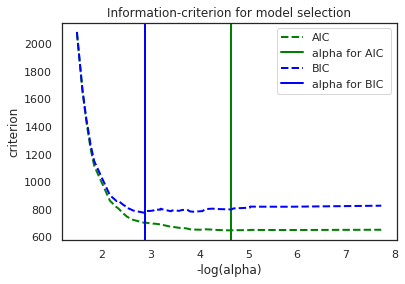

In [35]:
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train, y_train)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label= name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2,
                label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

In [36]:
lasso = Lasso(alpha= model_aic.alpha_) 
lasso.fit(X_train, y_train)

# Print R2 and MSE
print('Training r^2:', lasso.score(X_train, y_train))
print('Test r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Test MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Training r^2: 0.7160663479048328
Test r^2: 0.6995584814368063
Training MSE: 1.4319652904487161
Test MSE: 1.5190206926810907


/home/locsta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.174792769858, tolerance: 1.0485040490533506
  positive)


In [37]:
print(lasso.coef_)
print(lasso.intercept_)

[ 0.00325283 -0.20578768  0.09236789 -0.56752788  0.08118982 -0.46760496
 -0.67823228 -0.09657645  0.04870411 -0.31714965 -0.45844911 -0.19471587
  0.41189753  0.17309434  1.42260573  0.76557211 -0.09371771  1.37369242
 -2.50211289  1.16974816  0.96387034  0.78859393 -0.98666115 -2.13059181
 -0.12061307  0.75048302  0.2571703   0.25519653  0.17683306  0.33295912
 -0.28754571 -0.3587949 ]
77.41929625038912
